# Regime Detection Using Economic Variables

Renjie Pan (renjie.pan@nyu.edu)

Tianyu Zhang (tianyuzhang@nyu.edu)

Liang Zou (liazou@nyu.edu)

## Introduction

Economic factors usually lead to regime shifts in financial markets. In this project, we try to develop a two-state Hidden Markov Model (HMM) to detect the regime given time series economic data (financial turbulence, economic growth, and inflation) based on the article "Regime Shifts: Implications for Dynamic Strategies" (Kritzman, Page, Turkington, 2012). We will first compute equity turbulence and currency turbulence from S&P 500 sector indices and currencies versus U.S. dollar respectively. After that, we will perform exploratory data analysis (EDA) on these time series and conduct data smoothing to reduce the effects of extreme values (anomaly points). At the end, we use HMM to generate two regimes for each time series.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Dataset Description and Loading

The economic variables we will use are the following, where data were collected from Federal Reserve Economic Data (FRED) website:

$\textbf{Economic Growth}$: Quarter-over-quarter percentage change in seasonally adjusted U.S. real gross national product (GNP) from second quarter 1947 to second quarter 2019.

$\textbf{Inflation}$: Monthly percentage changes in seasonally adjusted US. Consumer Price Index (CPI) for all urban consumers from February 1947 to July 2019.

$\textbf{Sector Levels}$: 10 S&P 500 sector indices between December 1989 and September 2019.

$\textbf{Currency Pairs}$: G-10 currencies between December 1989 and September 2019.

In [2]:
directory = '/Users/liangzou/Desktop/Project-and-Presentation-Fall-2019/BNP Project/'
data_file_name = 'kritzman data.xlsx'

econ_growth = pd.read_excel(directory + data_file_name, 0)
inflation = pd.read_excel(directory + data_file_name, 1)
sector = pd.read_excel(directory + data_file_name, 2)
currency = pd.read_excel(directory + data_file_name, 3)

## Compute Financial Turbulence

We compute the financial turbulence using the following:

$$d_t = (y_t - \mu) \Sigma^{-1} (y_t - \mu)'$$

$y_t$: asset returns for period t

$\mu$: sample average historical returns

$\Sigma$: sample covariance matrix of historical returns

$\textbf{Equity Turbulence}$: Historical returns for past 10 years for S&P 500 sector indices

$\textbf{Currency Turbulence}$: Historical returns for past 3 years for G-10 currencies versus U.S. dollar (USD)

In [3]:
def compute_turbulence(df, years=3, alpha=0.01):
    '''
    Compute financial turbulence given time series data
        input: 
            df || DataFrame || a Dataframe includes Column "Date"
            years || integer || number of years to compute historical returns
            alpha || float || a punishment coefficient when inverse-coveriance is singular
        output: Turbulence || DataFrame || Column = ["Date", "Turbulence"]
    '''
    
    # Compute return for this series
    df_return = df.iloc[1:,1:].values / df.iloc[:-1,1:].values - 1
    distance = []
    error = []
    days_in_year = 252
    
    for i in range(years * days_in_year, len(df)-1):
        df_past_return = df_return[:i+1,:]
        # Compute historical mean return
        mu = np.mean(df_past_return, axis=0)
        try:
            # Compute inverse covariance matrix
            inv_sig = np.linalg.inv(np.cov(df_past_return.T))
        except:
            # Find days when covariance matrices are not invertible
            # and add small numbers to the diagonal
            sigma = np.cov(df_past_return.T)
            x = np.ones(sigma.shape[0])
            inv_sig = np.linalg.inv(sigma + np.diag(x)*alpha)
            error.append(i)

        y = np.array(df_return[i,:])
        d = np.dot(np.dot(y-mu, inv_sig),(y-mu).T)
        distance.append(d)
    
    Turbulence = pd.DataFrame({'Date': df['Date'][-len(distance):], 'Turbulence': distance})
    
    if error != []:
        print('Rows that produce singular covariance matrix')
        print(np.array(error) + 2)
    
    return Turbulence

In [4]:
sector_turbulence = compute_turbulence(sector, years=10)
currency_turbulence = compute_turbulence(currency, years=3)

## Exploratory Data Analysis and Data Smoothing

In [5]:
EDA_dataframe = pd.concat([econ_growth.describe(), inflation.describe(), 
           sector_turbulence['Turbulence'].describe(), currency_turbulence['Turbulence'].describe()], axis=1)
EDA_dataframe.columns = ['Economic Growth','Inflation','Equity Turbulence','Currency Turbulence']
EDA_dataframe.round(4)

,Economic Growth,Inflation,Equity Turbulence,Currency Turbulence
count,289.0000,870.0000,4905.0000,6669.0000
mean,3.2128,0.2847,10.6787,7.9320
std,3.8463,0.3443,18.0354,27.8651
min,-10.0000,-1.8000,0.0023,0.1927
25%,1.2000,0.1000,2.9631,2.7772
50%,3.1000,0.2000,5.2398,4.8709
75%,5.1000,0.4000,10.6382,8.7553
max,16.7000,2.0000,393.9824,2072.4420


In [6]:
currency_turbulence.loc[currency_turbulence['Turbulence'] > 2000, ['Date','Turbulence']]

,Date,Turbulence
6265,2015-01-15,2072.44202


The descriptive statistics show all 4 time series are little right-skewed with larger mean than median. The skewness is extremely large in equity and currency turbulence since a number of observations are greater than 100 whereas the means are 10.67 in equity and 7.93 in currency. 

On January 15th, 2015, the currency turbulence is 2072, which resulted from a special event: The Swiss National Bank abandoned cap on the Swiss franc’s exchange rate against the euro.

In [7]:
def data_smoothing(Turbulence):
    """
    Perform data smoothing on turbulence time series by taking square root and monthly average
    @Turbulence: Pandas DataFrame (raw time series)
    @return: Pandas DataFrame (smoothed time series)
    """
    # Take the square root of turbulence
    Turbulence['Sqrt_Turbulence'] = Turbulence.apply(lambda row: np.sqrt(row['Turbulence']), axis=1)
    
    # Compute monthly mean turbulence
    Turbulence['Month'] = Turbulence.apply(lambda row: np.datetime64(row['Date'],'M'), axis=1)
    Monthly_Turbulence = Turbulence.groupby(['Month'])['Sqrt_Turbulence'].mean()
    Monthly_Turbulence = Monthly_Turbulence.reset_index()
    Monthly_Turbulence = Monthly_Turbulence.rename(columns={"Month": "Date", "Sqrt_Turbulence": "Turbulence"})
    
    return Monthly_Turbulence

In [8]:
sector_turbulence_monthly = data_smoothing(sector_turbulence)
currency_turbulence_monthly = data_smoothing(currency_turbulence)

In [9]:
EDA_dataframe_turbulence = pd.concat([sector_turbulence['Turbulence'].describe(), 
                                      currency_turbulence['Turbulence'].describe(),
                                       sector_turbulence_monthly['Turbulence'].describe(), 
                                      currency_turbulence_monthly['Turbulence'].describe()], axis=1)
EDA_dataframe_turbulence.columns = ['Equity Turbulence','Currency Turbulence',
                        'Equity Turbulence (Monthly)','Currency Turbulence (Monthly)']
EDA_dataframe_turbulence.round(4)

,Equity Turbulence,Currency Turbulence,Equity Turbulence (Monthly),Currency Turbulence (Monthly)
count,4905.0000,6669.0000,237.0000,321.0000
mean,10.6787,7.9320,2.8126,2.4727
std,18.0354,27.8651,1.3794,0.7712
min,0.0023,0.1927,1.3590,1.3590
25%,2.9631,2.7772,1.9566,2.0127
50%,5.2398,4.8709,2.2435,2.3324
75%,10.6382,8.7553,3.0919,2.7635
max,393.9824,2072.4420,8.6802,8.2737


Due to right-skewness, we take the square root of turbulence and compute the monthly average. In comparing the summary statistics, their means and medians only change a little while the extreme values diminish significantly. Therefore, it is better to use smoothed equity turbulence and currency turbulence for further analysis.

## HMM based on Baum-Welch Algorithm

We develop Hidden Markov Model (HMM) with 2 states by default, which tries to estimate normal and event regimes. After calibrating the two-state HMM, we choose the regime with larger volatility ($\sigma$) as event regime and the one with smaller volatility ($\sigma$) as normal regime, since we believe event regime is more volatile while normal regime is more stable.

In [10]:
def fit_hmm(df, dim=2, max_iteration=1000, tolerance=1e-8):
    """
    Fit Hidden Markov Model based on Baum-Welch Algorithm.
    Here, we assume each regime is normally distributed with certain mean and variance.
    @df: Pandas DataFrame (time series data)
    @dim: integer (number of regimes or states)
    @max_iteration: interger (maximum number of iterations)
    @tolerance: float (tolerance for convergence)
    @return: Pandas DataFrame (Date, Probability of event regime)
             Event Regime (Persistence, mu, sigma)
             Normal Regime (Persistence, mu, sigma)
    """
    
    y = df.iloc[:,1].values
    
    random.seed(42)
    T = len(y)
    mu_y = np.mean(y)
    sigma_y = np.std(y)
    mu = [mu_y] * dim
    # mu = [x * mu_y for x in range(dim)]
    sigma = [sigma_y] * dim
    
    for d in range(dim): 
        mu[d] += np.asscalar(np.random.randn(1, 1) * sigma_y)
        # mu[d] += np.asscalar((0.1 * (d + 1))* sigma_y)
    
    # Initialize transition probability matrix and initial probability
    A = np.ones((dim, dim)) / dim
    p = np.ones((1, dim)) / dim
    PI = math.pi
    
    iteration = 1
    likelihood = [-2**31]
    change_likelihood = 2**31
    
    # Initialize matrices
    B = np.zeros((T, dim))
    forward = np.zeros((T, dim))
    backward = np.zeros((T, dim))
    scale = np.zeros((T, dim))
    smoothed = np.zeros((T, dim))
    xi = np.zeros((dim, dim, T))
    
    while change_likelihood > tolerance and iteration < max_iteration:
        
        for t in range(T):
            for d in range(dim):
                # Compute normal pdf for each time step, each regime
                B[t,d] = np.asscalar(1 / np.sqrt(2 * PI * sigma[d]**2) * np.exp(-0.5 * ((y[t] - mu[d])/sigma[d])**2))
        
        forward[0,:] = p * B[0,:]
        scale[0,:] = np.sum(forward[0,:])
        forward[0,:] = forward[0,:] / np.sum(forward[0,:])
        
        for t in range(1, T):
            forward[t,:] = np.dot(forward[t-1,:], A)*B[t,:]
            scale[t,:] = np.sum(forward[t,:])
            forward[t,:] = forward[t,:] / np.sum(forward[t,:])
            
        backward[T-1,:] = B[T-1,:]
        backward[T-1,:] = backward[T-1,:] / np.sum(backward[T-1,:])
        
        for t in range(T-2, -1 ,-1):
            backward[t,:] = np.dot(A, backward[t+1,:].T).T*B[t+1,:]
            backward[t,:] = backward[t,:] / np.sum(backward[t,:])
            
        for t in range(T):
            smoothed[t,:] = forward[t,:]*backward[t,:]
            smoothed[t,:] = smoothed[t,:] / np.sum(smoothed[t,:])
            
        for t in range(T-1):
            xi[:,:,t] = A * np.dot(forward[t,:].reshape((dim, 1)), (backward[t+1,:]*B[t+1,:]).reshape((1, dim)))
            xi[:,:,t] = xi[:,:,t] / np.sum(xi[:,:,t])
                
        p = smoothed[0,:]
        exp_num_transitions = np.sum(xi, axis = 2)
        
        for d in range(dim):
            A[d,:] = exp_num_transitions[d,:] / np.sum(xi[d,:,:])
            mu[d] = np.asscalar(np.dot(smoothed[:,d].T,y).T / np.sum(smoothed[:,d]))   
            sigma[d] = np.asscalar(np.sqrt(np.sum(smoothed[:,d]*(y-mu[d])*(y-mu[d])) / np.sum(smoothed[:,d])))
            
        likelihood.append(np.asscalar(np.sum(np.log(scale))))
        change_likelihood = np.asscalar(np.abs(likelihood[-1]-likelihood[-2]))
        iteration +=1
    
    print('Transition Probability =')
    print(np.round(A, 4))
    
    print('Mean =')
    print(np.round(mu, 4))
    
    print('Standard Deviation =')
    print(np.round(sigma, 4))
    
    print('Initial Probability =')
    print(np.round(p, 4))
    
    # Choose largest sigma as event regime and smallest sigma as normal regime
    event_index = np.argmax(sigma)
    normal_index = np.argmin(sigma)
    
    df['Event'] = pd.Series(smoothed[:,event_index])
    df['Normal'] = pd.Series(smoothed[:,normal_index])
    
    plt.figure(figsize=(9,6))
    plt.plot(df['Date'], df['Event'] * 100);
    plt.title('Probability of Event Regime')
    plt.ylabel('Percent')
    plt.xlabel('Year')
    
    # Get Persistence from transition probability matrix
    persistence = A.diagonal()
    
    return df[['Date','Event']], [persistence[event_index], mu[event_index], sigma[event_index]], \
            [persistence[normal_index], mu[normal_index], sigma[normal_index]]

## Regime Detection on Economic Growth

Transition Probability =
[[0.9796 0.0204]
 [0.0263 0.9737]]
Mean =
[2.9495 3.4456]
Standard Deviation =
[1.8954 4.9485]
Initial Probability =
[0. 1.]


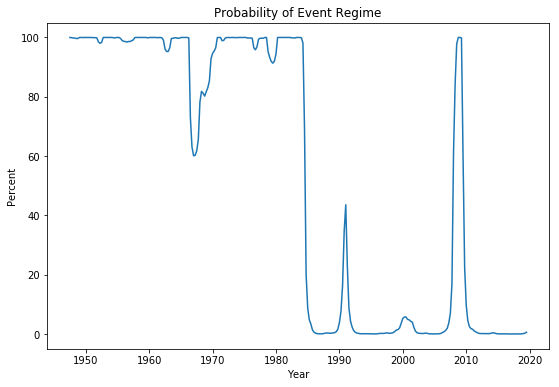

In [11]:
econ_hmm = fit_hmm(econ_growth)

Based on economic growth time series, the two regimes are normally distributed with mean 3.45, 2.95 and standard deviation 4.94, 1.90 respectively. The result shows the center of two regimes are close to each other but the first one is more volatile. 

Before 1980 or so, it mainly stays in event regimes. In the year of 2008, there exists a huge jump back to the event regime, due to financial crisis.

## Regime Detection on Inflation

Transition Probability =
[[0.9486 0.0514]
 [0.0144 0.9856]]
Mean =
[0.5402 0.2061]
Standard Deviation =
[0.5369 0.1997]
Initial Probability =
[1. 0.]


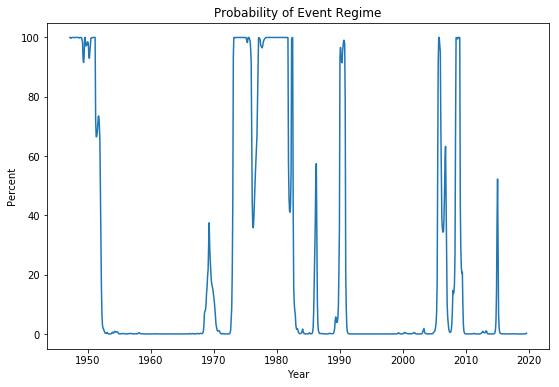

In [12]:
inflation_hmm = fit_hmm(inflation)

In terms of inflation, the normal regime has mean 0.21 with standard deviation 0.20 while the event regime produces a normal distribution with mean 0.54 and standard deviation 0.53. 

The inflation starts with event regime until 1952. After that, it stays in normal regime for around 15 years. There exists several peaks of event regime between 1972 and 1982. In the years of 1990 and 2008, the switches result from some global financial crisis. 

## Regime Detection on Equity turbulence

Transition Probability =
[[0.9846 0.0154]
 [0.0587 0.9413]]
Mean =
[2.1656 4.7168]
Standard Deviation =
[0.4219 1.4456]
Initial Probability =
[0. 1.]


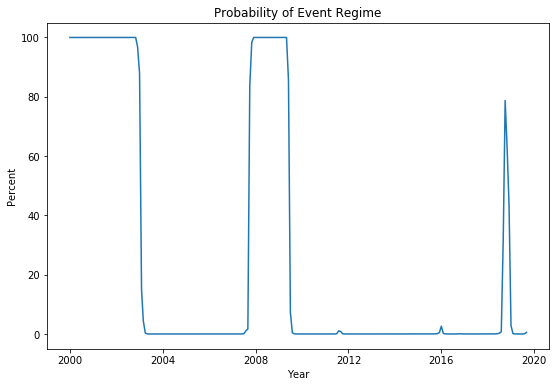

In [13]:
sector_hmm = fit_hmm(sector_turbulence_monthly)

The two regimes in equity turbulence are distinct to each other. The first one has mean 4.72 with standard deviation 1.45 while the later one has mean 2.17 and standard deviation 0.42.

After 2004, the majority of regimes are stable except for the years of 2008 and 2018 due to fluctations of financial markets.

## Regime Detection on Currency turbulence

Transition Probability =
[[0.9684 0.0316]
 [0.3385 0.6615]]
Mean =
[2.3292 4.1186]
Standard Deviation =
[0.4715 1.3779]
Initial Probability =
[1. 0.]


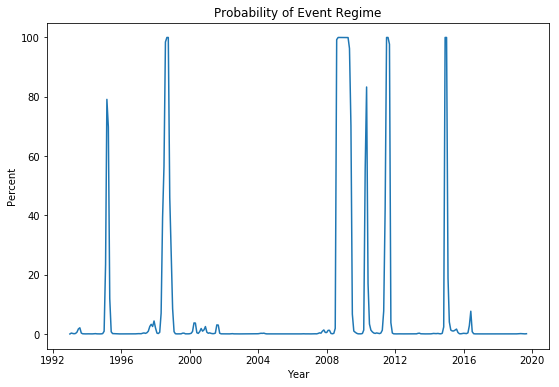

In [14]:
currency_hmm = fit_hmm(currency_turbulence_monthly)

Similar to equity turbulence, the first regime (event) in currency is normally distributed with mean 2.33 and volatility 3.67 while the second one has mean 4.12 and volatility 1.38. 

Every time a recession or global financial crisis happens, the series will switch to event regime. The equity turbulence becomes stable (normal regime) between 1998 and 2007.

## Summary

In [15]:
event_regimes = pd.DataFrame(np.stack([econ_hmm[1],inflation_hmm[1],sector_hmm[1],currency_hmm[1]]),
                            columns = ['Persistence (event)','Mu (event)','Sigma (event)'],
                            index = ['Economic Growth', 'Inflation', 'Equity Turbulence', 'Currency Turbulence'])
normal_regimes = pd.DataFrame(np.stack([econ_hmm[2],inflation_hmm[2],sector_hmm[2],currency_hmm[2]]),
                            columns = ['Persistence (normal)','Mu (normal)','Sigma (normal)'],
                            index = ['Economic Growth', 'Inflation', 'Equity Turbulence', 'Currency Turbulence'])
combine_regimes = pd.concat([event_regimes, normal_regimes], axis = 1)
combine_regimes.round(4)

,Persistence (event),Mu (event),Sigma (event),Persistence (normal),Mu (normal),Sigma (normal)
Economic Growth,0.9737,3.4456,4.9485,0.9796,2.9495,1.8954
Inflation,0.9486,0.5402,0.5369,0.9856,0.2061,0.1997
Equity Turbulence,0.9413,4.7168,1.4456,0.9846,2.1656,0.4219
Currency Turbulence,0.6615,4.1186,1.3779,0.9684,2.3292,0.4715


The first three columns represent the statistics in event regimes while the rest represents the normal regimes. It shows the means ($\mu$) and volatilies ($\sigma$) in event regimes are larger than normal regimes across all economic variables whereas the persistence in event regimes is lower.

## Output CSV Files

In [16]:
econ_hmm[0].to_csv(directory + 'economic_growth.csv', index = False)
inflation_hmm[0].to_csv(directory + 'inflation.csv', index = False)
sector_hmm[0].to_csv(directory + 'equity_turbulence.csv', index = False)
currency_hmm[0].to_csv(directory + 'currency_turbulence.csv', index = False)

## Related Questions

### 1. What are the assumptions behind the model?

(a) We assume there are only two regimes in total.

(b) Each regime is normally distributed with certain mean and standard deviation.

(c) Every regime is independent of each other (correlation is 0).

(d) Two regimes follow Markov property in the following:

$$p(y_1,y_2,...,y_n) = p(y_1)p(y_2|y_1)...p(y_n|y_{n-1},...,y_1) = p(y_1)p(y_2|y_1)...p(y_n|y_{n-1})$$

$$p(x_1, x_2, ..., x_T, y_1, ..., y_T) = p(x_0)\prod_{k=1}^T p(x_k|x_{k-1})p(y_k|x_k)$$
$$=p(y_1,...,y_T|x_1,...,x_T)p(x_1,...,x_T)$$

### 2. What happens if they are not true?

(a) It may cause underfitting in out-of-sample analysis if there exists more than 2 regimes.

(b) If assumption of normality is violated, it will lead to inaccurate estimations of extreme values due to fat-tail.

(c) If regimes are dependent, it will produce wrong estimations of covariance matrix.

(d) If Markov property is violated, we cannot compute the regime in terms of $x^{(n+1)} = x^{(n)} A$. As a result, we cannot iterate the time series as we did in our optimization algorithm.

### 3. What potential weaknesses and limitations can you identify in this approach?

(a) The algorithm is not robust to extremely large values (outliers). We original ran our HMM using raw data without data cleansing. Some time series fail to converge and produce NaN due to these anomaly observations. 

(b) The model does not consider correlations between regimes. In the future, we can introduce Gaussian Mixture Model with covariance matrix.

(c) Similar to K Means clustering, this algorithm will produce different results with different random initial points. In other words, the algorithm does not converge to global optimum every time. What we can to do is to collect more data or run the algorithm multiple times to see whether it converges to one state more often than the others.

## Reference

Kritzman, Mark, Sebastien Page, and David Turkington. "Regime shifts: Implications for dynamic strategies (corrected)." Financial Analysts Journal 68.3 (2012): 22-39.

Blackstone, Brian. "What Happened With the Swiss Franc?" The Wall Street Journal (2015). Retrieved from https://blogs.wsj.com/briefly/2015/01/15/what-happened-with-the-swiss-franc-the-short-answer/